# Calculate & Compare Feature Importance

...

**Data Sources**

- `data/interim/train_outliers.csv`: Best feature set configuration for ElasticNet pipeline / model.
- `models/full_pipe_final.pkl`: Best ElasticNet pipeline / model.


**Changes**

- 2019-04-04: Start notebook and perform calculations for ElasticNet model
- ...


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries,-load-data" data-toc-modified-id="Import-libraries,-load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries, load data</a></span></li><li><span><a href="#Get-feature-names" data-toc-modified-id="Get-feature-names-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get feature names</a></span></li><li><span><a href="#General-data-pre-processing-(outside-of-sklearn-pipeline)" data-toc-modified-id="General-data-pre-processing-(outside-of-sklearn-pipeline)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>General data pre-processing (outside of sklearn pipeline)</a></span><ul class="toc-item"><li><span><a href="#General-pre-processing" data-toc-modified-id="General-pre-processing-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>General pre-processing</a></span></li></ul></li><li><span><a href="#Explore-different-feature-set-options" data-toc-modified-id="Explore-different-feature-set-options-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Explore different feature set options</a></span><ul class="toc-item"><li><span><a href="#Define-pipeline-with-CV-to-evaluate-different-options" data-toc-modified-id="Define-pipeline-with-CV-to-evaluate-different-options-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Define pipeline with CV to evaluate different options</a></span></li><li><span><a href="#Explore-feature-sets" data-toc-modified-id="Explore-feature-sets-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Explore feature sets</a></span><ul class="toc-item"><li><span><a href="#Standard-train-set-(with-NaN-and-all-Outliers)" data-toc-modified-id="Standard-train-set-(with-NaN-and-all-Outliers)-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Standard train set (with NaN and all Outliers)</a></span></li><li><span><a href="#Train-set-without-columns-containing-NaN" data-toc-modified-id="Train-set-without-columns-containing-NaN-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Train set without columns containing NaN</a></span></li><li><span><a href="#Full-train-set-with-outliers-removed-for-top-correlating-columns" data-toc-modified-id="Full-train-set-with-outliers-removed-for-top-correlating-columns-4.2.3"><span class="toc-item-num">4.2.3&nbsp;&nbsp;</span>Full train set with outliers removed for top correlating columns</a></span></li><li><span><a href="#Full-train-set-with-outliers-removed-and-multi-correlation-columns-removed" data-toc-modified-id="Full-train-set-with-outliers-removed-and-multi-correlation-columns-removed-4.2.4"><span class="toc-item-num">4.2.4&nbsp;&nbsp;</span>Full train set with outliers removed and multi-correlation columns removed</a></span></li></ul></li><li><span><a href="#Final-Tuning-&amp;-Evaluation" data-toc-modified-id="Final-Tuning-&amp;-Evaluation-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Final Tuning &amp; Evaluation</a></span></li></ul></li><li><span><a href="#Apppendix:-Experiment-with-preprocessing-pipe-only" data-toc-modified-id="Apppendix:-Experiment-with-preprocessing-pipe-only-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Apppendix: Experiment with preprocessing pipe only</a></span></li></ul></div>

---

## Import libraries, load data

In [114]:
# Import libraries
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample

# My functions
import EDA_functions as EDA
import cleaning_functions as cleaning
from linRegModel_class import LinRegModel
import custom_transformers as transform

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns #, sns.set_style('whitegrid')
color = 'rebeccapurple'
%matplotlib inline

# Display settings
from IPython.display import display
pd.options.display.max_columns = 100

In [42]:
# Load data and models
housing_data = pd.read_csv('data/interim/train_opti_EN.csv')
full_pipe_EN = joblib.load('models/elastic_net_final.pkl')

## Get feature names

In [119]:
elastic_net_final = full_pipe_EN.named_steps['reg']
X = housing_data.drop(['SalePrice'], axis = 1)
y = housing_data['SalePrice']

In [120]:
# One-Hot-Encode X 
X = pd.get_dummies(X.copy())
display(X.head(2))
print(X.shape)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,...,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.094345,4.174387,9.041922,7,5,2003,2003,5.278115,6.559615,-4.60517,5.010635,6.752270,6.752270,6.749931,-4.60517,7.444249,1,-4.60517,2,1,3,0.0,8,0,2003.0,2,548,-4.605170,4.110874,-4.60517,-4.60517,-4.60517,-4.60517,-4.60517,2,2008,0,0,0,1,0,0,1,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,2.995732,4.382027,9.169518,6,8,1976,1976,-4.605170,6.885510,-4.60517,5.648974,7.140453,7.140453,-4.605170,-4.60517,7.140453,0,0.00000,2,0,3,0.0,6,1,1976.0,2,460,5.697093,-4.605170,-4.60517,-4.60517,-4.60517,-4.60517,-4.60517,5,2007,0,0,0,1,0,0,1,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


(1328, 262)


In [107]:
CHECK !!!! Try looking at data of of preprocessor as done in SMOTENC

# Re-arrange cols (pipe has cat before num, get_dummies not)
cols = X.columns.tolist()
cols = cols[36:] + cols[:36]  # last column to first column
X = X[cols]

# Check result
display(X.head(2))
print(X.shape)

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,...,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,1,0,4.094345,4.174387,9.041922,7,5,2003,2003,5.278115,6.559615,-4.60517,5.010635,6.752270,6.752270,6.749931,-4.60517,7.444249,1,-4.60517,2,1,3,0.0,8,0,2003.0,2,548,-4.605170,4.110874,-4.60517,-4.60517,-4.60517,-4.60517,-4.60517,2,2008
1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0,0,0,1,0,2.995732,4.382027,9.169518,6,8,1976,1976,-4.605170,6.885510,-4.60517,5.648974,7.140453,7.140453,-4.605170,-4.60517,7.140453,0,0.00000,2,0,3,0.0,6,1,1976.0,2,460,5.697093,-4.605170,-4.60517,-4.60517,-4.60517,-4.60517,-4.60517,5,2007


(1328, 262)


In [116]:
def print_coef_weights(X_train, y_train, model, n_bootstrap=10):
    '''
    Output estimates for coefficient weights and corresponding error. 
    The error is calculated using bootstrap resamplings of the data.

    ARGUMENTS:
    model: fitted model instance
    n_bootstrap: int number of bootstrap resamplings

    RETURNS:
    coefs_df: dataframe holding estimate for coeff weights and error
    '''
    coefs_df = pd.DataFrame(index=X_train.columns)
    coefs_df['effect'] = model.coef_.round(1)

    # calculate modulo of coefs_ for sorting the df only, drop then
    coefs_df['abs_coefs'] = np.abs(coefs_df['effect'])
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    coefs_df.drop('abs_coefs', axis=1, inplace=True)

#     # add uncertainty with help of bootstrap resamling
#     np.random.seed(1)
#     err = np.std([model.fit(*resample(X_train, y_train)) \
#         .coef_ for i in range(100)], 0)
#     coefs_df['error'] = err.round(0)

    return coefs_df

In [117]:
print_coef_weights(X, y, elastic_net_final)

,effect
BldgType_Duplex,0.1
ExterQual_Fa,0.1
Neighborhood_Mitchel,-0.1
SaleCondition_Abnorml,0.1
BsmtFinType2_Rec,0.1
SaleType_ConLw,-0.1
Exterior1st_AsbShng,-0.1
SaleType_COD,0.1
RoofStyle_Shed,0.1
Utilities_AllPub,0.1


99 features, reduction of 62.21%


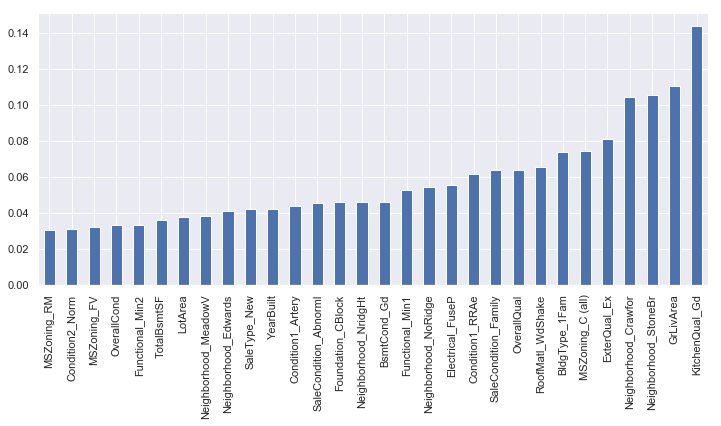

In [121]:
feature_importance = pd.Series(index = X.columns, data = np.abs(elastic_net_final.coef_))
n_selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))
feature_importance.sort_values().tail(30).plot(kind = 'bar', figsize = (12,5));

In [4]:
# Initialize a scikit-learn model object of choice
model_simple = ElasticNetCV(alphas=[0.03, 0.05, 0.09], copy_X=True, cv=5, eps=0.001, 
                            fit_intercept=True, l1_ratio=[0.6, 0.9, 1.0], max_iter=3000, 
                            n_alphas=100, n_jobs=-1)

# Create an instance of the LinRegModel class by passing df, target variable and model object
elastic_net_simple = LinRegModel(raw_data, 'SalePrice', model_simple)

# Output instance
display(elastic_net_simple)

ElasticNetCV(alphas=[0.03, 0.05, 0.09], copy_X=True, cv=5, eps=0.001,
       fit_intercept=True, l1_ratio=[0.6, 0.9, 1.0], max_iter=3000,
       n_alphas=100, n_jobs=-1, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)

In [5]:
# Perform the modelling
elastic_net_simple.go_quickDirty()

C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase t

C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase t

In [6]:
# Output result
elastic_net_simple

ElasticNetCV(alphas=[0.03, 0.05, 0.09], copy_X=True, cv=5, eps=0.001,
       fit_intercept=True, l1_ratio=[0.6, 0.9, 1.0], max_iter=3000,
       n_alphas=100, n_jobs=-1, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)

RMSE on test data 33373.76, r2-score 0.80.

In [7]:
# Check best values
print(model_simple.alpha_)
print(model_simple.l1_ratio_)
print(model_simple.n_iter_)

0.09
0.9
3000


## General data pre-processing (outside of sklearn pipeline)
Pre-processing steps that take place before data is pipelined

### General pre-processing

In [8]:
# Disable warning
pd.set_option('mode.chained_assignment', None)

# Create and clean training set with variables from the EDA notebook
train_data = (raw_data
              .pipe(cleaning.change_dtypes, cols_to_category=raw_data.select_dtypes(object))
              .pipe(cleaning.delete_columns, cols_to_delete=cols_to_del)
              .pipe(cleaning.apply_log, cols_to_transform=cols_to_log)
             )

train_data.drop(outliers_to_del, inplace=True)
train_data.dropna(subset=['MasVnrArea', 'MasVnrType', 'Electrical'], inplace=True);

'MiscFeature successfully deleted'

'PoolQC successfully deleted'

'FireplaceQu successfully deleted'

'Alley successfully deleted'

'Id successfully deleted'

'Fence successfully deleted'

In [9]:
# check results
display(train_data.shape)

(1447, 75)

## Explore different feature set options

### Define pipeline with CV to evaluate different options

In [10]:
def evaluate_feature_sets(df, reg, scorer, cv=StratifiedKFold(3)):
    
    # Split input features and target label
    X_train = df.drop('SalePrice', axis=1)
    y_train = df['SalePrice'].copy()
    
    # Define cat and num feature columns
    categorical_features = X_train.select_dtypes(include=['category']).columns
    numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
    assert len(categorical_features) + len(numeric_features) == df.shape[1] - 1
    
    ## Assemble pipeline (define function)
    
    # level 1 - two separate pipes for cat and num features
    numeric_transformer = Pipeline(steps=[
        ('imputer_n', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
            ])

    categorical_transformer = Pipeline(steps=[
        ('imputer_c', SimpleImputer(strategy='constant', fill_value='missing')),
        ('ohe', OneHotEncoder(handle_unknown='ignore')),
            ])

    # level 2 - wrap the two level 1 pipes into a ColumnTransformer
    preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features),
                         ])

    # level 3 - pipe it with a classifier
    full_pipe = Pipeline(steps=[
                       ('preprocessor', preprocessor),
                       ('reg', model_simple),
                               ]) 
    
    # Evaluate imputing strategy for missing num values and scaling
    parameters = {
        'preprocessor__num__imputer_n__strategy': ['mean', 'median'],
        'preprocessor__num__scaler' : [None, StandardScaler()]
                 }

    cv = GridSearchCV(full_pipe, param_grid=parameters, scoring=scorer, n_jobs=-1, iid=False,
                      cv=cv, error_score='raise', return_train_score=False, verbose=1)

    grid = cv.fit(X_train, y_train) 
    grid_results = grid.cv_results_

    # Here I have to go for the smallest score (CV expects utility function
    # and not cost function, see Hands-OnML p. 70)
    best_score = np.sqrt(np.min(grid_results['mean_test_score']))
    
    return grid_results, best_score

In [11]:
 # Define input parameters
scorer = make_scorer(mean_squared_error)
reg = elastic_net_simple # 'optimized baseline model'
cv = 3

### Explore feature sets

#### Standard train set (with NaN and all Outliers)

In [12]:
# Run pipeline
grid_results, best_score = evaluate_feature_sets(train_data, reg=reg, scorer=scorer, cv=cv)

# Print best score
print(best_score)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    5.2s finished


0.13817449507839052


In [13]:
display(pd.DataFrame(grid_results).nsmallest(1, 'mean_test_score'))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num__imputer_n__strategy,param_preprocessor__num__scaler,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,0.539413,0.033475,0.073747,0.012108,mean,"StandardScaler(copy=True, with_mean=True, with...",{'preprocessor__num__imputer_n__strategy': 'me...,0.018117,0.020913,0.018247,0.019092,0.001289,4


**Result:** Best score for imputation with mean and applied StandardScaler(). (The latter has an impact but imputation with 'mean' or 'median' leads to more or less the same result.)

#### Train set without columns containing NaN

In [14]:
# Create List of Columns containing NaN
nan_cols = []
for col in train_data.columns:
    if train_data[col].isnull().sum() > 0:
        nan_cols.append(col)

In [15]:
# Check results
nan_cols

['LotFrontage',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

In [16]:
# Create train set without missing values (drop nan_cols)
train_data_reduced = train_data.drop(nan_cols, axis=1)

assert train_data_reduced.isnull().sum().sum() == 0
assert train_data_reduced.shape[1] == train_data.shape[1] - len(nan_cols)

In [17]:
# Run pipeline
grid_results, best_score = evaluate_feature_sets(train_data_reduced, 
                                                 reg=reg, scorer=scorer, cv=cv)

# Print best score
print(best_score)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.2s finished


0.13817450160297168


**Result:** Results are really, really close. Imputing with Mean scores slightly better than elimination of the columns.

#### Full train set with outliers removed for top correlating columns

In [18]:
# Remove Outliers for remaining top_corr_cols
top_corr_columns = set(train_data.columns).intersection(set(top_corr_columns))
train_data_outliers = cleaning.remove_outliers_IQR_method(train_data, top_corr_columns)

GarageCars
Rows removed: 5

GarageYrBlt
Rows removed: 0

GrLivArea
Rows removed: 7

SalePrice
Rows removed: 21

YearRemodAdd
Rows removed: 0

OverallQual
Rows removed: 0

FullBath
Rows removed: 0

1stFlrSF
Rows removed: 2

GarageArea
Rows removed: 16

TotalBsmtSF
Rows removed: 49

YearBuilt
Rows removed: 6

TotRmsAbvGrd
Rows removed: 17


Rows removed in total: 123



In [19]:
# Run pipeline
grid_results, best_score = evaluate_feature_sets(train_data_outliers, 
                                                 reg=reg, scorer=scorer, cv=cv)

# Print best score
print(best_score)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.2s finished


0.12788435560048148


**Result:** Result on data with removed outliers leads to a better score.

In [20]:
# Check params
display(pd.DataFrame(grid_results).nsmallest(1, 'mean_test_score'))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num__imputer_n__strategy,param_preprocessor__num__scaler,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,0.632533,0.157336,0.053019,0.012758,mean,"StandardScaler(copy=True, with_mean=True, with...",{'preprocessor__num__imputer_n__strategy': 'me...,0.017282,0.015354,0.016427,0.016354,0.000789,4


#### Full train set with outliers removed and multi-correlation columns removed

In [21]:
# Remove Outliers for remaining top_corr_cols in the reduced data set
# GarageYrBlt was a the top_corr_features that was dropped above
cols_multi = set(train_data_outliers.columns).intersection(set(['1stFloor', 'GarageArea', 'FirstFlSF']))
train_data_multi = cleaning.delete_columns(train_data_outliers,  cols_multi)

assert train_data_multi.shape[1] == train_data_outliers.shape[1] - len(cols_multi)

'GarageArea successfully deleted'

In [22]:
# Run pipeline
grid_results, best_score = evaluate_feature_sets(train_data_multi, 
                                                 reg=reg, scorer=scorer, cv=cv)

# Print best score
print(best_score)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.3s finished


0.12791427125897528


**Result:** Result on data with removed multi_col(s) is slightly worse.

### Final Tuning & Evaluation

The full train_set with mean imputation, scaling and outlier removal scored the best results.

In [23]:
X, y = train_data_outliers.drop(['SalePrice'], axis = 1), train_data_outliers['SalePrice']
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [24]:
# Assemble pipeline (define function)
def build_final_pipe(X_train, y_train, reg):
    """Build a pipeline for preprocessing and modelling.
    
    ARGUMENTS:
        X_train: training features (df or array)
        y_train: training labels (df or array)
        reg: classifier (sk-learn model object)
        
    RETURNS:
        full_pipe: pipeline object
    """
    
    # Define cat and num feature columns
    categorical_features = X_train.select_dtypes(include=['category']).columns
    numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
    assert len(categorical_features) + len(numeric_features) == X_train.shape[1]
    
    # level 1 - two separate pipes for cat and num features
    numeric_transformer = Pipeline(steps=[
        ('imputer_n', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
            ])

    categorical_transformer = Pipeline(steps=[
        ('imputer_c', SimpleImputer(strategy='constant', fill_value='missing')),
        ('ohe', OneHotEncoder(handle_unknown='ignore')),
            ])

    # level 2 - wrap the two level 1 pipes into a ColumnTransformer
    preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features),
                         ])

    # level 3 - pipe it with a classifier
    full_pipe = Pipeline(steps=[
                       ('preprocessor', preprocessor),
                       ('reg', reg),
                               ]) 
    
    return full_pipe

In [25]:
elastic_net_final = ElasticNetCV(l1_ratio=.9, 
                                 eps=1e-3, n_alphas=100, fit_intercept=True, 
                                 normalize=True, precompute='auto', max_iter=3000, 
                                 tol=0.0001, cv=6, copy_X=True, verbose=0, n_jobs=-1, 
                                 positive=False, random_state=0)

full_pipe_final = build_final_pipe(X_train, y_train, elastic_net_final) # cv on parameters
full_pipe_final.fit(X_train, y_train)

y_pred = full_pipe_final.predict(X_test)

In [26]:
print('Test r2 score: ', r2_score(y_test, y_pred))
test_mse = mean_squared_error(y_pred, y_test)
test_rmse = np.sqrt(test_mse)
print('Test RMSE: %.4f' % test_rmse)

Test r2 score:  0.9072201374723157
Test RMSE: 0.1146


In [27]:
joblib.dump(full_pipe_final, 'models/elastic_net_final.pkl')

['models/elastic_net_final.pkl']

---

## Apppendix: Experiment with preprocessing pipe only 

In [28]:
X, y = train_data_outliers.drop(['SalePrice'], axis = 1), train_data_outliers['SalePrice']

In [29]:
# Assemble pipeline (define function)
def build_preprocessing_pipe(X):
    """Build a pipeline for preprocessing and modelling.
    
    ARGUMENTS:
        X_train: training features (df or array)
        
    RETURNS:
        preprocessor: pipeline object
    """
    
    # Define cat and num feature columns
    categorical_features = X_train.select_dtypes(include=['category']).columns
    numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
    assert len(categorical_features) + len(numeric_features) == X_train.shape[1]
    
    # level 1 - two separate pipes for cat and num features
    numeric_transformer = Pipeline(steps=[
        ('imputer_n', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
            ])

    categorical_transformer = Pipeline(steps=[
        ('imputer_c', SimpleImputer(strategy='constant', fill_value='missing')),
        ('ohe', OneHotEncoder(handle_unknown='ignore')),
            ])

    # level 2 - wrap the two level 1 pipes into a ColumnTransformer
    preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features),
                         ])
    
    return preprocessor

In [30]:
preprocessor = build_preprocessing_pipe(X)
X_tr = preprocessor.fit_transform(X)

---